In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 15

In [ ]:
!mkdir Major_Project

In [ ]:
def loadCsv(path):

  csv_path = Path(path)
  if csv_path.is_file():
    data = pd.read_csv(csv_path, encoding= 'unicode_escape')
  else:
    raise ValueError('Error while reading the csv file.')
  return data

preprocessed_data = loadCsv('/content/drive/MyDrive/Leapfrog_internship/Major Project/commerce_data.csv')

In [ ]:
preprocessed_data.head(3)

,invoice_num,invoice_date,stock_code,description,quantity,unit_price,spend_amount,customer_id,country
0,536365,2010-12-01 08:26:00,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom


In [ ]:
def get_attributes_info(data):

  info = defaultdict(list)
  info['Count'], info['dtypes']  = data.count(), data.dtypes.values
  info['Missing_values'] = data.isnull().sum().values
  info['Missing_values (%)'] = info['Missing_values'] / data.shape[0] * 100
  info['Unique'] = data.nunique()
  attributes_info = pd.DataFrame(info)

  return attributes_info

get_attributes_info(preprocessed_data)

,Count,dtypes,Missing_values,Missing_values (%),Unique
invoice_num,392098,int64,0,0.0,18531
invoice_date,392098,object,0,0.0,17281
stock_code,392098,object,0,0.0,3663
description,392098,object,0,0.0,3875
quantity,392098,int64,0,0.0,301
unit_price,392098,float64,0,0.0,440
spend_amount,392098,float64,0,0.0,2810
customer_id,392098,int64,0,0.0,4338
country,392098,object,0,0.0,37






---


**Insights in basket price of customers.** 

---


Every entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. Collecting all the purchases made during a single order to recover the total amount spent in an order.

Task in steps:
1. Calculating the total amount of sterlings spend in an order.
2. Determing the mean time for the orders.

In [ ]:
preprocessed_data.invoice_date = pd.to_datetime(preprocessed_data.invoice_date)
preprocessed_data.customer_id = preprocessed_data.customer_id.astype('int64')

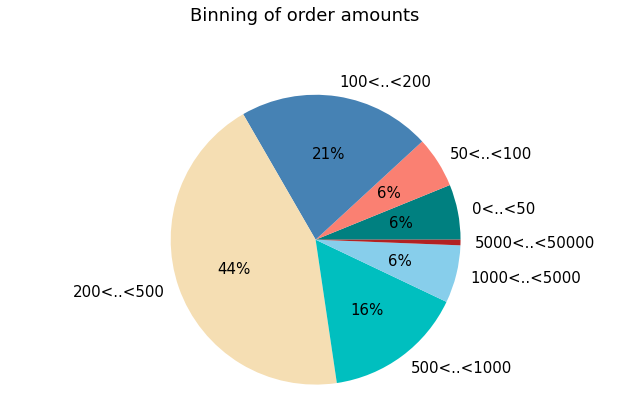

In [ ]:
def basket_price_calculation():

  temp_df = preprocessed_data.groupby(by=['customer_id', 'invoice_num'], as_index=False)['spend_amount'].sum()
  basket_price = temp_df.rename(columns = {'spend_amount':'basket_price'})
  preprocessed_data['invoice_date_int'] = preprocessed_data['invoice_date'].astype('int64')
  temp_df = preprocessed_data.groupby(by=['customer_id', 'invoice_num'], as_index=False)['invoice_date_int'].mean()
  preprocessed_data.drop('invoice_date_int', axis = 1, inplace = True)
  basket_price.loc[:, 'invoice_date'] = pd.to_datetime(temp_df['invoice_date_int'])
  basket_price.sort_values('customer_id')[:6]

  return basket_price

def plot_basket_price(basket_price):

  price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
  count_price = []
  for index, price in enumerate(price_range):
      if index == 0: continue
      val = basket_price[(basket_price['basket_price'] < price) &
                        (basket_price['basket_price'] > price_range[index-1])]['basket_price'].count()
      count_price.append(val)  
  f, ax = plt.subplots(figsize=(11, 6))
  colors = ['teal', 'salmon', 'steelblue', 'wheat', 'c', 'skyblue','firebrick']
  labels = [ '{}<..<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
  sizes  = count_price
  explode = [0.0 if sizes[count] < 100 else 0.0 for count in range(len(sizes))]
  ax.pie(sizes, explode = explode, labels=labels, colors = colors,
        autopct = lambda percent:'{:1.0f}%'.format(percent) if percent > 1 else '',
        shadow = False, startangle=0)
  ax.axis('equal')
  f.text(0.5, 1.01, "Binning of order amounts", ha='center', fontsize = 18);

  return None
  
basket_price_df = basket_price_calculation()
plot_basket_price(basket_price_df)


It is observed that vast majority of customers are spending more than 200 sterlings in an order.


---



**Dicovering patterns for each country.**


---
The customers that make purchases are from  37 different countries, analyzing differnt patterns of the countries.

1. Number of orders from different countries.
2. Number of customers from different countries.
3. Amount spent by customers from different countries.

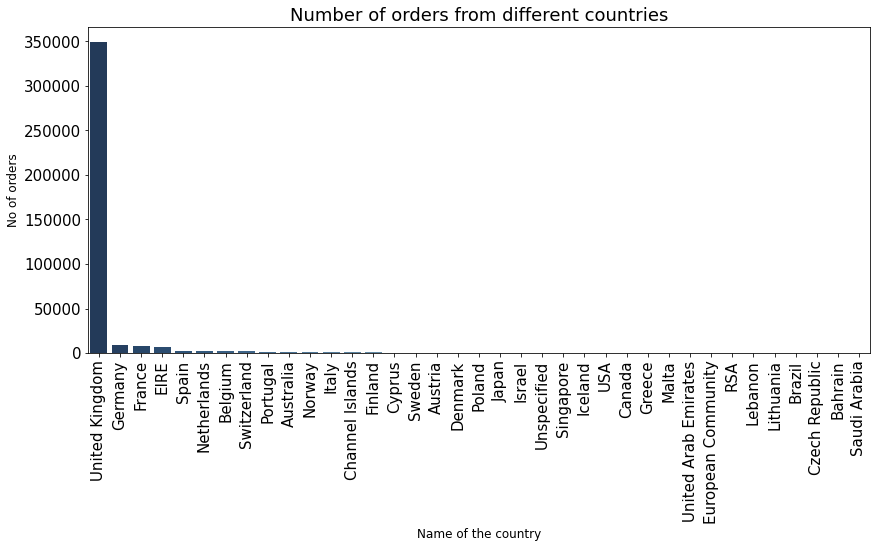

In [ ]:
group_country_orders = preprocessed_data.groupby(by=['country'], as_index=False)['invoice_num'].count().sort_values(['invoice_num', "country"], ascending = False)

def bar_plot(country_values, x_axis, y_axis,  xlabel, ylabel, title, palette_value='Blues_r'):

  sns.barplot(data = country_values, x = country_values[x_axis], y = country_values[y_axis],  palette=palette_value, saturation=0.5)
  plt.xlabel(xlabel, fontsize=12)
  plt.ylabel(ylabel, fontsize=12)
  plt.title(title, fontsize=18)
  plt.xticks(rotation=90);
  plt.show()

  return None

bar_plot(group_country_orders,'country', 'invoice_num', 'Name of the country', 'No of orders', 'Number of orders from different countries')


In [ ]:
preprocessed_data.loc[preprocessed_data.country=="United Kingdom"].shape[0] / preprocessed_data.shape[0] * 100


88.91731148845442

The purchases from UK comprises of almost 89% which is very high incomparison to others and as a result other countries purchases look diminishing, but that is not the case so removing UK from the row and seeing the other top 15 countries that make purchases.

In [ ]:
group_country_orders.drop([group_country_orders.index[0]], inplace=True)

In [ ]:
group_country_customers = preprocessed_data.groupby(by=['country'], as_index=False)['customer_id'].count().sort_values(['customer_id', "country"], ascending = False)
group_country_customers.drop([group_country_customers.index[0]], inplace=True)


In [ ]:
group_country_amount = preprocessed_data.groupby(by=['country'], as_index=False)['spend_amount'].sum().sort_values(['spend_amount', "country"], ascending = False)
group_country_amount.drop([group_country_amount.index[0]], inplace=True)


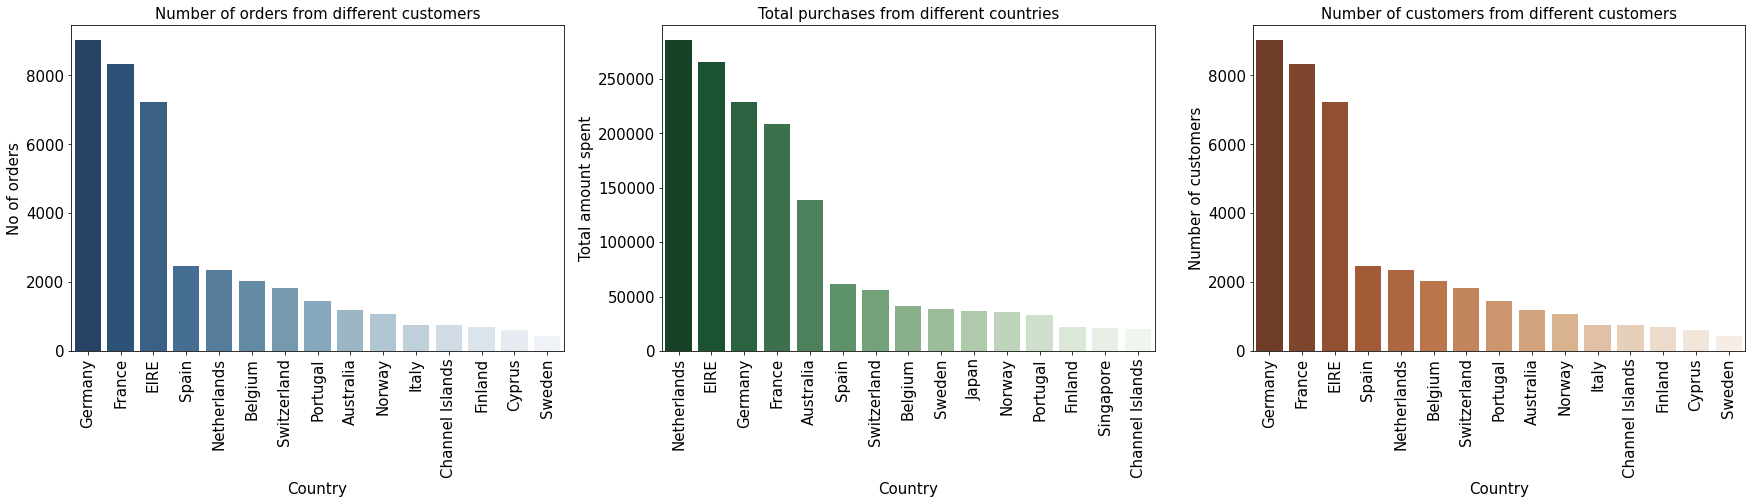

In [ ]:
def visualize_countries_of_customers(orders_per_country, customers_per_country, amount_per_country):
  
  f = plt.figure(figsize = (30, 6))
  ax = f.add_subplot(131)
  sns.barplot(data = orders_per_country, x = orders_per_country['country'], y = orders_per_country['invoice_num'],  palette='Blues_r', saturation=0.5, order=orders_per_country.sort_values(['invoice_num'], ascending = False).country)
  ax.set_title('Number of orders from different customers', fontsize=15)
  plt.xlabel('Country')
  plt.ylabel('No of orders')
  plt.xticks(rotation=90)

  ax = f.add_subplot(132)
  sns.barplot(data = amount_per_country, x = amount_per_country['country'], y = amount_per_country['spend_amount'],  palette='Greens_r', saturation=0.5, order=amount_per_country.sort_values(['spend_amount'], ascending = False).country)
  ax.set_title('Total purchases from different countries', fontsize = 15)
  plt.xlabel('Country')
  plt.ylabel('Total amount spent')
  plt.xticks(rotation=90)
  
  ax = f.add_subplot(133)
  sns.barplot(data = customers_per_country, x = customers_per_country['country'], y = customers_per_country['customer_id'],  palette='Oranges_r', saturation=0.5, order=customers_per_country.sort_values(['customer_id'], ascending = False).country)
  ax.set_title('Number of customers from different customers', fontsize = 15)
  plt.xlabel('Country')
  plt.ylabel('Number of customers')
  plt.xticks(rotation=90)

  return None

visualize_countries_of_customers(group_country_orders.iloc[0:15], group_country_customers[0:15], group_country_amount[0:15])


It is seen that most of the products are selled within UK, followed by the other european nations.


---




**Discovering patterns in description**

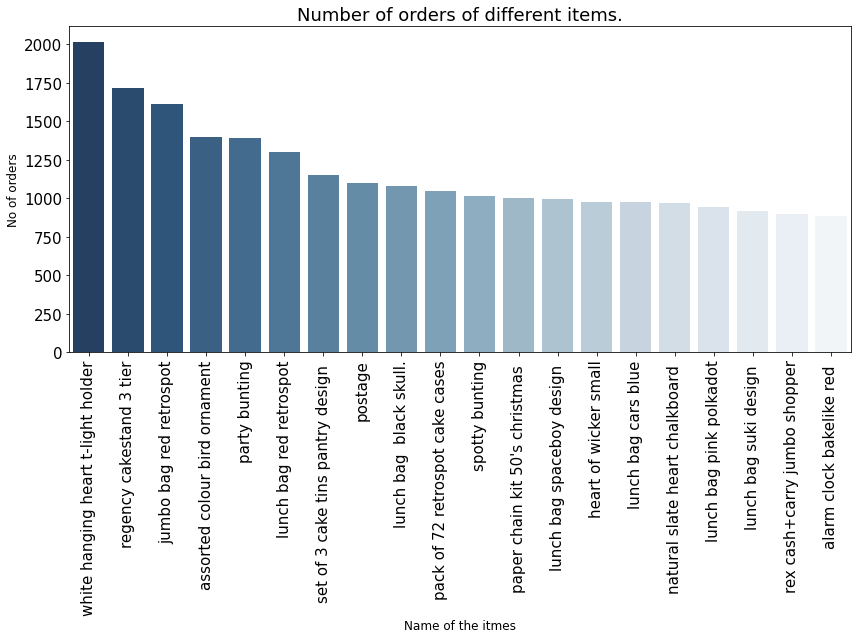

In [ ]:
group_items_orders = preprocessed_data.groupby(by=['description'], as_index=False)['invoice_num'].count().sort_values(['invoice_num', "description"], ascending = False)
bar_plot(group_items_orders.head(20),'description', 'invoice_num', 'Name of the itmes', 'No of orders', 'Number of orders of different items.')


There are in total 3875 unique descritptions, the maximum number of orders for a description is 2000 and minimum is 1.



---




**Discovering patterns in number of orders with time**


---



In [ ]:
commerce_data = preprocessed_data
commerce_data.head()

,invoice_num,invoice_date,stock_code,description,quantity,unit_price,spend_amount,customer_id,country
0,536365,2010-12-01 08:26:00,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


In [ ]:
commerce_data.insert(loc=2, column='year_month', value=commerce_data['invoice_date'].map(lambda x: 100*x.year + x.month))
commerce_data.insert(loc=3, column='month', value=commerce_data.invoice_date.dt.month)
commerce_data.insert(loc=4, column='week', value=commerce_data.invoice_date.apply(lambda x: x.strftime('%W')))
commerce_data.insert(loc=5, column='day', value=(commerce_data.invoice_date.dt.dayofweek)+1)
commerce_data.insert(loc=6, column='hour', value=commerce_data.invoice_date.dt.hour)

In [ ]:

def bar_plot_single_colour(country_values, x_axis, y_axis,  xlabel, ylabel, title):

  sns.barplot(data = country_values, x = country_values[x_axis], y = country_values[y_axis],  color='cadetblue', saturation=0.5)
  plt.xlabel(xlabel, fontsize=12)
  plt.ylabel(ylabel, fontsize=12)
  plt.title(title, fontsize=18)
  plt.xticks(rotation=90)
  plt.show()

  return None

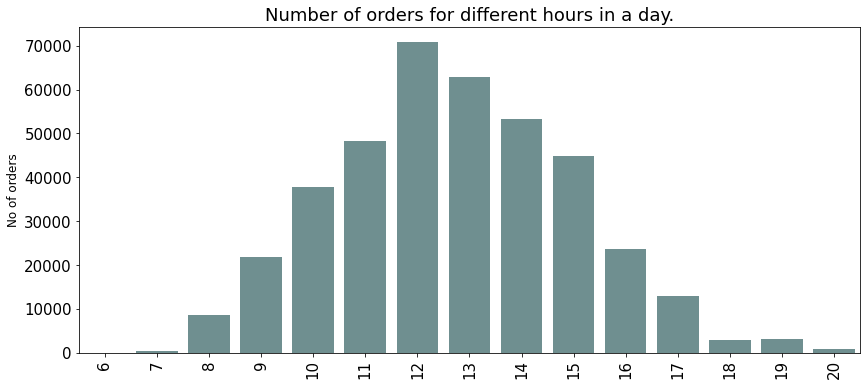

In [ ]:
order_per_hour = commerce_data.groupby(by=['hour'], as_index=False)['invoice_num'].count()
bar_plot_single_colour(order_per_hour, 'hour', 'invoice_num', '', 'No of orders', 'Number of orders for different hours in a day.')


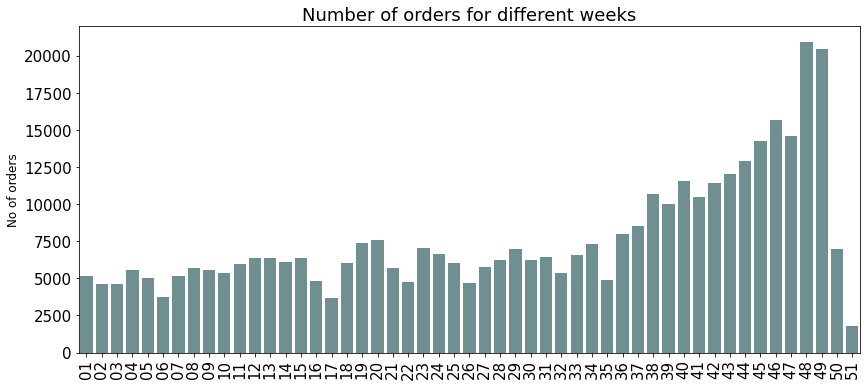

In [ ]:
order_by_week = commerce_data.groupby(by=['week'], as_index=False)['invoice_num'].count()
bar_plot_single_colour(order_by_week, 'week', 'invoice_num', '', 'No of orders', 'Number of orders for different weeks')


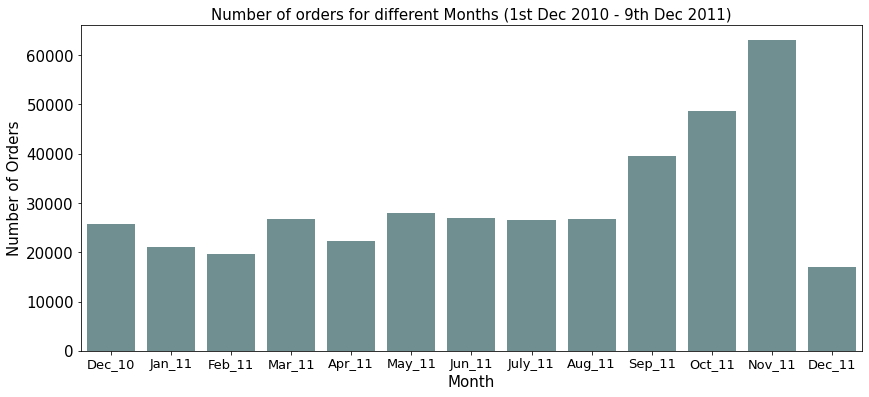

In [ ]:
def orders_per_month_vis():

  ax = sns.barplot(data = orders_per_month, x = 'year_month', y = 'invoice_num',  color='cadetblue', saturation=0.5)
  ax.set_xlabel('Month',fontsize=15)
  ax.set_ylabel('Number of Orders',fontsize=15)
  ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
  ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
  plt.show()

  return None

orders_per_month = commerce_data.groupby(by=['year_month'], as_index=False)['invoice_num'].count()
orders_per_month_vis()

This can also be visualized using line plot to see the trend.


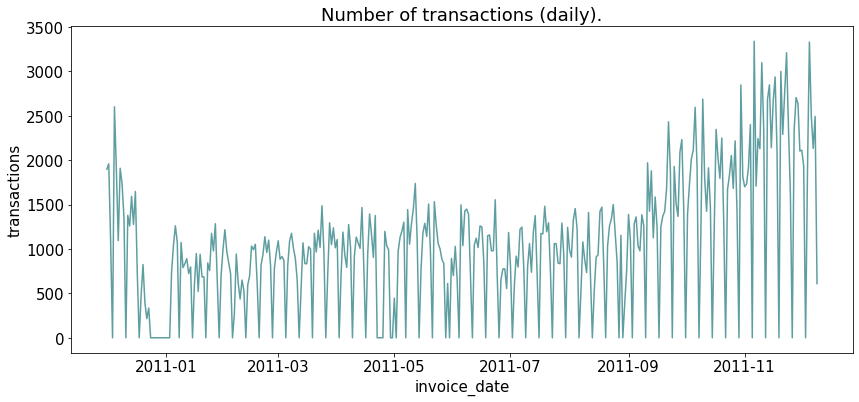

In [ ]:
time_grouping = commerce_data.groupby('invoice_date')[['invoice_num']].count()
time_grouping.columns = ['transactions']

def line_plot(agg_posts, title):

  sns.lineplot(data = agg_posts, x = 'invoice_date', y = 'transactions', color='cadetblue')
  plt.title(title)

time_grouping_daily = time_grouping.resample('D').apply(sum)
line_plot(time_grouping_daily, "Number of transactions (daily).")


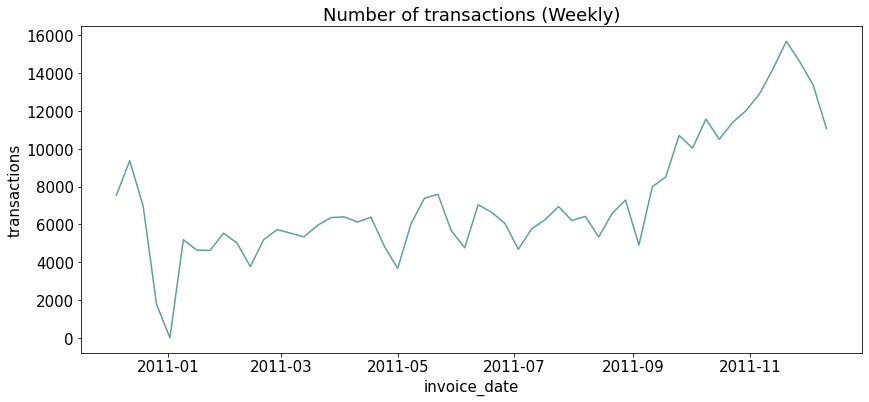

In [ ]:
time_grouping_weekly = time_grouping.resample('W').apply(sum)
line_plot(time_grouping_weekly, "Number of transactions (Weekly)")

In the above time and orders analysis following things were observed:
* The peak hours of sales were in mid daytimes.
* The sales has been growing almost linearly from the 36th week but suddenly dropped for the week 50 and 51.
* The sales has been growing almost linearly from the month of september while it dropped for december.

The less amount of orders in the December must be beacause the data for december month is only provided for 9 days, i.e. till 9th of December due to which there is oviously less number of orders placed.
The rise in the sales maybe caused because of the arrival of the festival time.



---




**Discovering patterns in number of orders made by different customers**


---



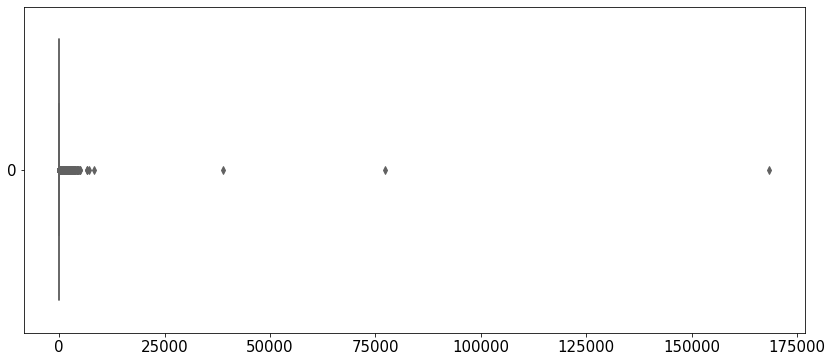

In [ ]:
ax = sns.boxplot(data=(preprocessed_data['spend_amount']), orient="h", palette="Blues_r")

In [ ]:
df_free = preprocessed_data[preprocessed_data.spend_amount == 0]
df_free.head(3)

,invoice_num,invoice_date,year_month,month,week,day,hour,stock_code,description,quantity,unit_price,spend_amount,customer_id,country


*Add more number of rows for seeing the reason behind null values as done in another one.*

There are some customers who are making very high amount of purchases (reason of the outliers) , they have a good value to company, seeing this further.

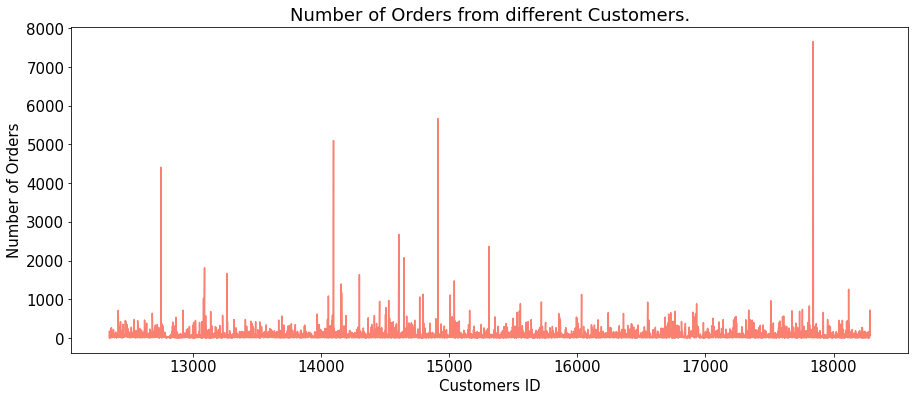

In [ ]:
def orders_per_customer_vis(x_axis, y_axis):
    
  plt.subplots(figsize=(15,6))
  plt.plot( x_axis, y_axis, color='salmon')
  plt.xlabel('Customers ID')
  plt.ylabel('Number of Orders')
  plt.title('Number of Orders from different Customers.')
  plt.show()

orders_per_customer = commerce_data.groupby(by=['customer_id'], as_index=False)['invoice_num'].count()
orders_per_customer_vis(orders_per_customer.customer_id, orders_per_customer.invoice_num)

In [ ]:
def get_ordered_count(data, grouping_element, count_element):

  ordered_value = data.groupby(by=[grouping_element], as_index=False)[count_element].count()

  return (ordered_value.sort_values([count_element, grouping_element], ascending = False))

def get_ordered_sum(data, grouping_element, count_element):

  ordered_value = data.groupby(by=[grouping_element], as_index=False)[count_element].sum()
  
  return (ordered_value.sort_values([count_element, grouping_element], ascending = False))

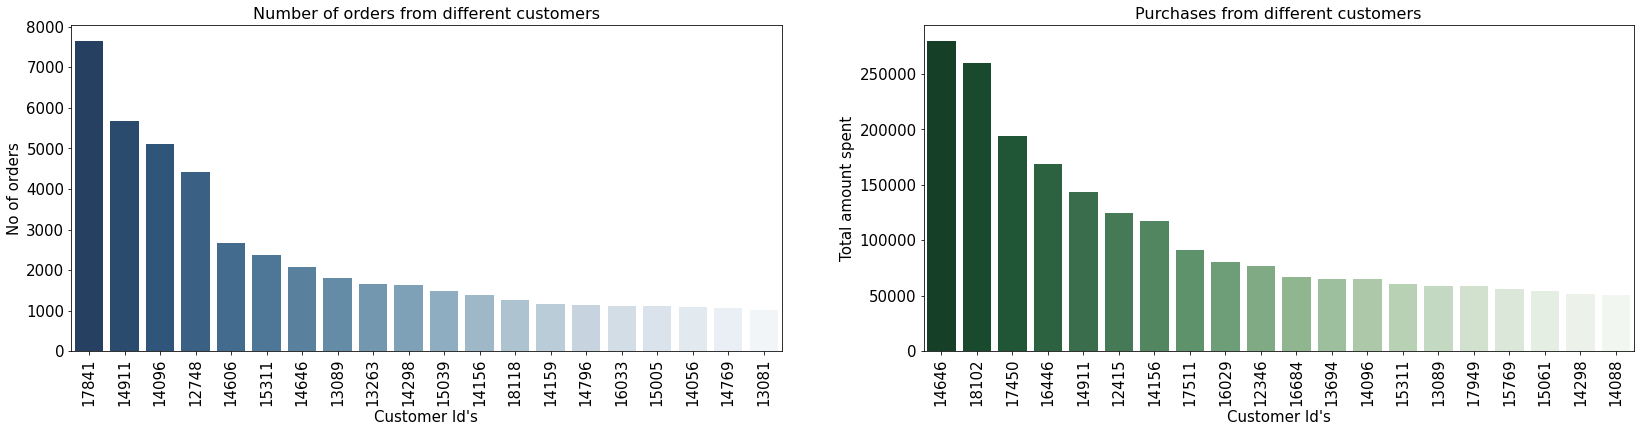

In [ ]:
def visualize_customers_purchases(orders_per_customer, amount_per_customer):
  
  f = plt.figure(figsize = (28, 6))
  ax = f.add_subplot(121)
  sns.barplot(data = orders_per_customer, x = orders_per_customer['customer_id'], y = orders_per_customer['invoice_num'],  palette='Blues_r', saturation=0.5, order=orders_per_customer.sort_values(['invoice_num'], ascending = False).customer_id)
  ax.set_title('Number of orders from different customers', fontsize=16)
  plt.xlabel('Customer Id\'s')
  plt.ylabel('No of orders')
  plt.xticks(rotation=90)

  ax = f.add_subplot(122)
  sns.barplot(data = amount_per_customer, x = amount_per_customer['customer_id'], y = amount_per_customer['spend_amount'],  palette='Greens_r', saturation=0.5, order=amount_per_customer.sort_values(['spend_amount'], ascending = False).customer_id)
  ax.set_title('Purchases from different customers', fontsize = 16)
  plt.xlabel('Customer Id\'s')
  plt.ylabel('Total amount spent')
  plt.xticks(rotation=90)

  return None

visualize_customers_purchases(get_ordered_count(commerce_data, 'customer_id', 'invoice_num').head(20), get_ordered_sum(commerce_data, 'customer_id', 'spend_amount').head(20))


* There are some common customers in both the plots, they make both high number of orders and spend a lot of money in those orders.

* Some customers do make a lots of orders but are not buying the expensive stuffs or higher quantities, so they should be presented with different adequate amount of products.

* Some customers do not make a lot of orders but on the orders they make, they buy expensive or higher quantities, as a result they spend more amount of money

* The customers belonging to both plots can be treated in a way, the ones spending a lot of money can be approached in a certain way and the ones making a lots of orders can be approached in another way, to get the most effective outcomes.